# NN for initial wave type determination

 * Radek Hofman, Dec 2017

In [2]:
%matplotlib inline
#%load_ext sql  # uncomment if you have ipython-sql installed
import matplotlib.pyplot as plt
import numpy
import math
import pandas
import os
from IPython.display import Image

### Introduction

* Neural networks are used in StaPro for initial wave type determination (iwt) for 3C stations
* The purpose is to assign an initial wave type to each arrival
* The system comprises of a sequence of three binary classifiers: 
    - **Step 1:** the system tries to distinguish between noise (N) and a signal (P or S wave)
    - **Step 2:** if signal: is it P or S wave?
    - **Step 3:** if P: is it regional P or teleseismic P?
* Currently, all the NNs uses the same weights trained on data from **STKA** station
* We will attempt to re-train the network using data from different station for **Step 1**

The sequence of binary classifiers is illustrated on the following diagram from *Sereno and Gagan, 1993*:

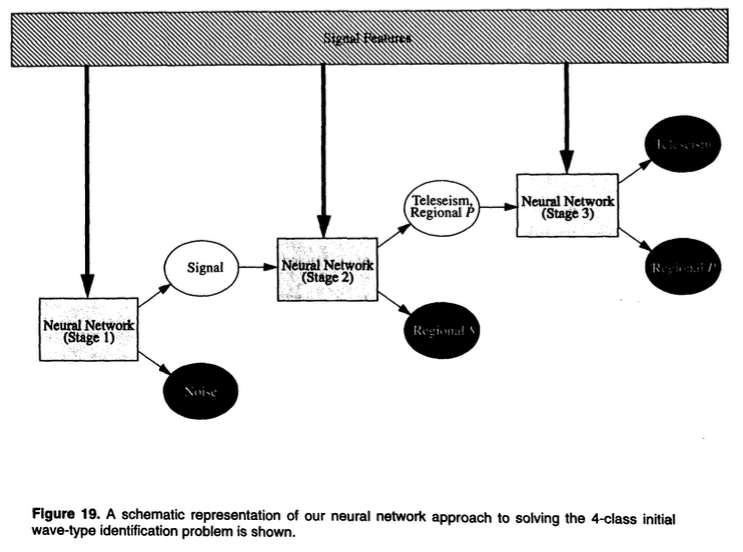

In [3]:
Image(filename=os.path.join('pics', 'StaPro_nn_cascade.png')) 

* Binary classifiers in each step are implemented as a neural network (multiplayer perceptron) with:
    - 15 inputs
    - one hidden layer with 6 units
    - 2 ouput (for each class one)
* NNs in all steps have the same topology and take the same inputs (features):
 1. **$period$**: Dominant period of the detected phase.
 2. **$rect$**: Signal rectilinearity
 3. **$plans$**: Signal planarity
 4. **$inang_1$**: Long-axis incidence angle
 5. **$inang_3$**: Short-axis incidence angle
 6. **$hmxmn$**: Ratio of the maximum to minimum horizontal amplitude:
 7. **$hvratp$**: Ratio of horizontal-to-vertical power: hvratp   snn see, where szzYsnn, and
 8. **$hvrat$**: Similar to hvratp, however measured at the time of the maximum three-
component amplitude.
 9. **$N_{after} - N_{before}$**: Difference between the number of arrivals before and after the
arrival in question within a fixed time window  60 seconds by default). The value of the number difference is scaled to a small range near  1 by dividing by 10.
 10. **$T_{after} - T_{before}$**: Mean-time di erence between the arrival in question and those arrivals before and after it within a fixed time window  60 seconds by default). The value of the mean time difference is scaled to a small range near  1 by dividing by 100.
 11. **$htov_1$**: Horizontal-to-vertical power ratio in an octave frequency band centered at 0.25 Hz.
 12. **$htov_2$**: Horizontal-to-vertical power ratio in an octave frequency band centered at 0.5 Hz.
 13. **$htov_3$**: Horizontal-to-vertical power ratio in an octave frequency band centered at 1.0 Hz.
 14. **$htov_4$**: Horizontal-to-vertical power ratio in an octave frequency band centered at 2.0 Hz.
 15. **$htov_5$**: Horizontal-to-vertical power ratio in an octave frequency band centered at 4.0 Hz.
 
 In the following diagram from *Sereno and Gagan (1993)* we see inputs - slowness was later removed:

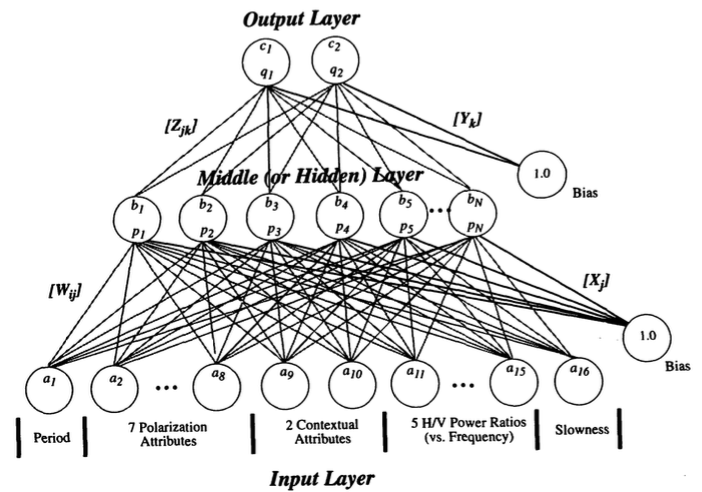

In [4]:
Image(filename=os.path.join('pics', 'nn_topology.png')) 

## Data

### Which phases we have in IDC DB?

In [ ]:
HOFMAN@repadb > select sta, iphase, count(iphase) from reb.arrival where sta='LPAZ' group by sta, iphase order by count(iphase);

STA    IPHASE   COUNT(IPHASE)                                                                                                                                                                                                                                                 
------ -------- -------------                                                                                                                                                                                                                                                 
LPAZ   PS                   1                                                                                                                                                                                                                                                 
LPAZ   T                    1                                                                                                                                                                                                                                                 
LPAZ   PcS                  1                                                                                                                                                                                                                                                 
LPAZ   pPcP                 1                                                                                                                                                                                                                                                 
LPAZ   PKP2ab               1                                                                                                                                                                                                                                                 
LPAZ   SKKP                 1                                                                                                                                                                                                                                                 
LPAZ   H                    1                                                                                                                                                                                                                                                 
LPAZ   P3KP                 2                                                                                                                                                                                                                                                 
LPAZ   sP                   2                                                                                                                                                                                                                                                 
LPAZ   PKP2bc               2                                                                                                                                                                                                                                                 
LPAZ   pPKPab               2                                                                                                                                                                                                                                                 
LPAZ   SKKPbc               2                                                                                                                                                                                                                                                 
LPAZ   SS                   3                                                                                                                                                                                                                                                 
LPAZ   SP                   3                                                                                                                                                                                                                                                 
LPAZ   PKKP                 5                                                                                                                                                                                                                                                 
LPAZ   SKPab                5                                                                                                                                                                                                                                                 
LPAZ   PKKPab               5                                                                                                                                                                                                                                                 
LPAZ   P3KPbc               7                                                                                                                                                                                                                                                 
LPAZ   ScS                 10                                                                                                                                                                                                                                                 
LPAZ   PKP2                12                                                                                                                                                                                                                                                 
LPAZ   PKhKP               14                                                                                                                                                                                                                                                 
LPAZ   Pdiff               16                                                                                                                                                                                                                                                 
LPAZ   pPKP                21                                                                                                                                                                                                                                                 
LPAZ   SKP                 30                                                                                                                                                                                                                                                 
LPAZ   SKPbc               39                                                                                                                                                                                                                                                 
LPAZ   ScP                 42                                                                                                                                                                                                                                                 
LPAZ   pPKPbc              46                                                                                                                                                                                                                                                 
LPAZ   PKKPbc              49                                                                                                                                                                                                                                                 
LPAZ   PKiKP               56                                                                                                                                                                                                                                                 
LPAZ   Rg                  73                                                                                                                                                                                                                                                 
LPAZ   pP                 100                                                                                                                                                                                                                                                 
LPAZ   PP                 106                                                                                                                                                                                                                                                 
LPAZ   PcP                266                                                                                                                                                                                                                                                 
LPAZ   Sn                 268                                                                                                                                                                                                                                                 
LPAZ   Px                 350                                                                                                                                                                                                                                                 
LPAZ   PKPab              353                                                                                                                                                                                                                                                 
LPAZ   Sx                 706                                                                                                                                                                                                                                                 
LPAZ   PKP                770                                                                                                                                                                                                                                                 
LPAZ   Lg                1108                                                                                                                                                                                                                                                 
LPAZ   PKPbc             1136                                                                                                                                                                                                                                                 
LPAZ   Pg                1761                                                                                                                                                                                                                                                 
LPAZ   S                 1963                                                                                                                                                                                                                                                 
LPAZ   N                 3964                                                                                                                                                                                                                                                 
LPAZ   tx                6644                                                                                                                                                                                                                                                 
LPAZ   Pn               11200                                                                                                                                                                                                                                                 
LPAZ   LR               17889                                                                                                                                                                                                                                                 
LPAZ   P                74103

#### Which arrivals exist both in **IDCX** and **REB**?

In [ ]:
HOFMAN@repadb > select r.sta, r.iphase, count(r.iphase) from reb.arrival r join idcx.arrival i on i.arid=r.arid where i.sta='LPAZ' group by r.sta, r.iphase order by count(r.iphase);

STA    IPHASE   COUNT(R.IPHASE)                                                                                                                                                                                                                                               
------ -------- ---------------                                                                                                                                                                                                                                               
LPAZ   PcP                    1                                                                                                                                                                                                                                               
LPAZ   PKP                    2                                                                                                                                                                                                                                               
LPAZ   Sn                    21                                                                                                                                                                                                                                               
LPAZ   Rg                    71                                                                                                                                                                                                                                               
LPAZ   Px                   350                                                                                                                                                                                                                                               
LPAZ   Sx                   706                                                                                                                                                                                                                                               
LPAZ   Lg                   894                                                                                                                                                                                                                                               
LPAZ   Pg                  1728                                                                                                                                                                                                                                               
LPAZ   N                   3964                                                                                                                                                                                                                                               
LPAZ   tx                  6644                                                                                                                                                                                                                                               
LPAZ   Pn                 10988                                                                                                                                                                                                                                               
LPAZ   P                  57558

### Which features we use?

* Besides features number 9 and 10, all are computed by DFX and stored in tables **IDCX.AMP3C** and **IDCX.APMA**.
* We will use a reduced set of features excluding #9 and #10 compared to that used by *Sereno and Gagan, 1993*.
* We take just wave of following types: ('N','P','Pn','Pg','S','Sn')
* As train and test data we use labeled phases from **REB.ARRIVAL**

Following SQL query gives us what we want, more or less:

%%sql select 
         r.sta, 
         r.arid, 
         r.time, 
         r.iphase, 
         r.per, 
         ap.rect, 
         ap.plans, 
         ap.inang1, 
         ap.inang3, 
         ap.hmxmn, 
         ap.hvratp, 
         ap.hvrat, 
         a1.htov "htov1",  
         a2.htov "htov2", 
         a3.htov "htov3", 
         a4.htov "htov4", 
         a5.htov "htov5" 
      from reb.arrival r 
      join idcx.apma ap on r.arid=ap.arid 
      join idcx.amp3c a1 on r.arid=a1.arid 
      join idcx.amp3c a2 on r.arid=a2.arid 
      join idcx.amp3c a3 on r.arid=a3.arid 
      join idcx.amp3c a4 on r.arid=a4.arid 
      join idcx.amp3c a5 on r.arid=a5.arid 
      where 
        r.sta='LPAZ' and 
        a1.cfreq=0.25 and 
        a2.cfreq=0.5 and 
        a3.cfreq=1 and 
        a4.cfreq=2 and 
        a5.cfreq=4 and 
        r.iphase in ('N','P','Pn','Pg','S','Sn') 
      order by r.time

CSV export of data is in file LPAZ_REB_data.txt.

### Load data

In [5]:
#let's get data frame from our csv
df_orig = pandas.read_csv(os.path.join('data', 'LPAZ_REB_data.txt'))
#rename columns - strip and tranform to upper - because the are in fix format, e.g. '    RECT'
df_orig.columns = [x.strip().upper() for x in df_orig.keys()]

In [6]:
df_orig.keys()

Index([u'STA', u'ARID', u'TIME', u'IPHASE', u'PER', u'RECT', u'PLANS',
       u'INANG1', u'INANG3', u'HMXMN', u'HVRATP', u'HVRAT', u'HTOV1', u'HTOV2',
       u'HTOV3', u'HTOV4', u'HTOV5'],
      dtype='object')

In [7]:
df_orig

,STA,ARID,TIME,IPHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,LPAZ,28795,929262713,P,0.444444,0.965456,0.833532,25.890320,88.515434,1.753121,0.153874,0.260174,1.060979,0.232627,0.268429,0.272675,0.718754
1,LPAZ,29061,929266140,P,0.444444,0.956462,0.962309,3.471021,87.424024,2.342310,0.045488,0.110112,0.321216,1.026410,0.212828,0.321905,0.312222
2,LPAZ,29985,929277418,P,0.666667,0.947165,0.971356,10.160299,81.425875,1.554862,0.069524,0.135528,0.782917,0.185320,0.132944,0.105860,0.812514
3,LPAZ,30069,929278214,P,0.444444,0.935142,0.961990,13.196104,80.118251,1.615320,0.093982,0.093982,0.386305,0.963945,0.136582,0.161179,0.233876
4,LPAZ,32008,929306517,Pn,0.222222,0.924817,0.764040,23.646144,89.678181,2.857154,0.179756,0.225282,0.232112,0.241615,0.269782,0.154196,0.129759
5,LPAZ,32551,929314516,P,0.666667,0.964792,0.974479,28.330720,76.201916,2.645395,0.181670,0.181670,0.492163,0.073957,0.189346,0.069044,0.355626
6,LPAZ,49369,929507198,P,0.333333,0.983332,0.928823,25.376418,73.011782,2.301760,0.130400,0.163436,0.254550,0.561142,0.419133,0.130574,0.118723
7,LPAZ,50323,929517537,P,0.666667,0.891155,0.911534,6.493017,88.616137,3.352336,0.115228,0.156560,0.888229,1.017596,0.098426,0.379276,0.783499
8,LPAZ,53715,929552037,Pn,0.444444,0.957518,0.892848,44.986616,62.408952,3.038431,0.521126,1.012321,4.218094,0.500349,1.790995,0.691329,0.849543
9,LPAZ,57121,929585102,P,0.444444,0.953783,0.897991,11.373746,77.235197,2.592700,0.066846,0.253918,0.508627,0.496510,0.194844,0.346379,0.101210


In [8]:
# We want to classify signal on Noise vs. Waves of type P or S
# copy dataframe to get IPHASE in {0,1}: 0 for P, 1 otherwise
df = df_orig.copy(deep=True)
df.loc[df_orig.IPHASE == 'N       ', 'IPHASE'] = 0
df.loc[df_orig.IPHASE != 'N       ', 'IPHASE'] = 1

In [9]:
print(df_orig.loc[20,'IPHASE'])
print(df.loc[20,'IPHASE'])

N       
0


In [10]:
# to be sure, convert to numeric
df.apply(pandas.to_numeric, errors='ignore')

,STA,ARID,TIME,IPHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,LPAZ,28795,929262713,1,0.444444,0.965456,0.833532,25.890320,88.515434,1.753121,0.153874,0.260174,1.060979,0.232627,0.268429,0.272675,0.718754
1,LPAZ,29061,929266140,1,0.444444,0.956462,0.962309,3.471021,87.424024,2.342310,0.045488,0.110112,0.321216,1.026410,0.212828,0.321905,0.312222
2,LPAZ,29985,929277418,1,0.666667,0.947165,0.971356,10.160299,81.425875,1.554862,0.069524,0.135528,0.782917,0.185320,0.132944,0.105860,0.812514
3,LPAZ,30069,929278214,1,0.444444,0.935142,0.961990,13.196104,80.118251,1.615320,0.093982,0.093982,0.386305,0.963945,0.136582,0.161179,0.233876
4,LPAZ,32008,929306517,1,0.222222,0.924817,0.764040,23.646144,89.678181,2.857154,0.179756,0.225282,0.232112,0.241615,0.269782,0.154196,0.129759
5,LPAZ,32551,929314516,1,0.666667,0.964792,0.974479,28.330720,76.201916,2.645395,0.181670,0.181670,0.492163,0.073957,0.189346,0.069044,0.355626
6,LPAZ,49369,929507198,1,0.333333,0.983332,0.928823,25.376418,73.011782,2.301760,0.130400,0.163436,0.254550,0.561142,0.419133,0.130574,0.118723
7,LPAZ,50323,929517537,1,0.666667,0.891155,0.911534,6.493017,88.616137,3.352336,0.115228,0.156560,0.888229,1.017596,0.098426,0.379276,0.783499
8,LPAZ,53715,929552037,1,0.444444,0.957518,0.892848,44.986616,62.408952,3.038431,0.521126,1.012321,4.218094,0.500349,1.790995,0.691329,0.849543
9,LPAZ,57121,929585102,1,0.444444,0.953783,0.897991,11.373746,77.235197,2.592700,0.066846,0.253918,0.508627,0.496510,0.194844,0.346379,0.101210


In [11]:
# columns corresponding to input
x_indices = ['PER', 'RECT', 'PLANS', 'INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 
             'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5']
# columns corresponding to output
y_indices = ['IPHASE']

In [12]:
from sklearn.utils import shuffle
numpy.random.seed(11)

# Now in Ns we have rows with iphase N and the rest in noN
noN = shuffle(df[df['IPHASE']==1])
N   = shuffle(df[df['IPHASE']==0])

noN_X = noN[x_indices]
noN_Y = noN[y_indices]
N_X = N[x_indices]
N_Y = N[y_indices]
print(noN_X.shape, noN_Y.shape, N_X.shape, N_Y.shape)

noNm_X = noN_X.as_matrix()
noNm_Y = noN_Y.as_matrix()
Nm_X = N_X.as_matrix()
Nm_Y = N_Y.as_matrix()
print(noNm_X.shape, noNm_Y.shape, N_X.shape, N_Y.shape)

((70229, 13), (70229, 1), (3962, 13), (3962, 1))
((70229, 13), (70229, 1), (3962, 13), (3962, 1))


#### Create train and test sets

In [13]:
max_index = min(N.shape[0], noN.shape[0])
thr = 0.75
thr_index = int(thr * max_index)
 
# train set
X_train = numpy.vstack([noNm_X[:thr_index, :], Nm_X[:thr_index, :]])
Y_train = numpy.vstack([noNm_Y[:thr_index, :], Nm_Y[:thr_index, :]])
# test set
X_test = numpy.vstack([noNm_X[thr_index:max_index, :], Nm_X[thr_index:max_index, :]])
Y_test = numpy.vstack([noNm_Y[thr_index:max_index, :], Nm_Y[thr_index:max_index, :]])
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

((5942, 13), (5942, 1))
((1982, 13), (1982, 1))


## Train NN for distinguishing of N vs. {P,S}

In [14]:
import numpy
from keras.models import Sequential
from keras.layers import Dense

Using Theano backend.


In [15]:
n_input = 13  # a sub-set of original inputs
numpy.random.seed(11)

# create model
model = Sequential()
model.add(Dense(13, input_dim=n_input, activation='sigmoid'))
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam', 
    metrics = ['accuracy'])

#### Print model summary

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 84        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


#### Train

In [17]:
# fit the model
history = model.fit(X_train, Y_train, 
          epochs=300, 
          batch_size=32, 
          verbose=0,
          shuffle=True,
          validation_data=(X_test, Y_test))

#### Plot training progress

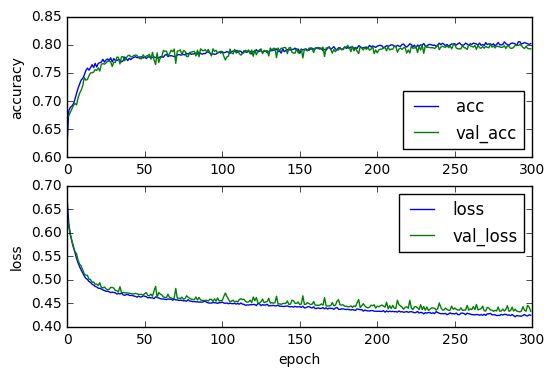

In [18]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(history.history['acc'], label='acc')
ax.plot(history.history['val_acc'], label='val_acc')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
ax = fig.add_subplot(212)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

#### Calculate confusion matrix

In [19]:
Y_true = Y_test
# calculate predicted values
Y_pred = model.predict(X_test)
# predictions are outputted as floats from [0,1]
print(Y_pred[:10])

[[ 0.87134165]
 [ 0.69180167]
 [ 0.81410855]
 [ 0.8150143 ]
 [ 0.86389792]
 [ 0.10882626]
 [ 0.26004827]
 [ 0.63850838]
 [ 0.65045005]
 [ 0.90992278]]


In [20]:
from sklearn.metrics import confusion_matrix

# we must translate it to 0, 1 based on thresholding at 0.5
# where < 0.5 set to 0, to 1 otherwise
Y_pred = numpy.where(Y_pred < 0.5, 0, 1)

# calculate confusion matrix
conf_mat = confusion_matrix(Y_true, Y_pred)
print(conf_mat)

[[763 228]
 [183 808]]


In [21]:
Y_test.shape

(1982, 1)

#### Save complete trained model for later use

In [22]:
#save model and weights
model.save('LPAZ_model.h5')